In [2]:
!pip install -q torch

tcmalloc: large alloc 1073750016 bytes == 0x58ec6000 @  0x7fef438bd2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import pandas as pd
import os
from google.colab import drive
import string
from google.colab import files
import re
from ast import literal_eval
from googleapiclient.http import MediaFileUpload
import numpy as np

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
folder_path = os.getcwd() + '/gdrive/My Drive/NLP/'

In [0]:
PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

train = folder_path + 'data/snli_train.tsv'
val = folder_path + 'data/snli_val.tsv'

In [0]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [words2id[word] if word in words2id else UNK_IDX for word in tokens]
        indices_data.append(index_list)
    return indices_data

In [0]:
words2id = pkl.load(open(folder_path + "data/words2id.pkl", "rb"))
idx2words = pkl.load(open(folder_path +"data/idx2words.pkl", "rb"))
loaded_embeddings = pkl.load(open(folder_path +"data/embedding_matrix.pkl", "rb"))

train_data = pd.read_csv(train,delimiter='\t',encoding='utf-8')
val_data = pd.read_csv(val,delimiter='\t',encoding='utf-8')

train_data['label_num'] = train_data['label'].apply(lambda x: 0 if str(x) == 'contradiction' else 1 if str(x) == 'neutral' else 2)
val_data['label_num'] = val_data['label'].apply(lambda x: 0 if str(x) == 'contradiction' else 1 if str(x) == 'neutral' else 2)

train_label = list(train_data['label_num'])
val_label = list(val_data['label_num'])

In [0]:
train_tokens_1 = pkl.load(open(folder_path + "data/train_data_tokens_1.p", "rb"))
train_tokens_2 = pkl.load(open(folder_path +"data/train_data_tokens_2.p", "rb"))

val_tokens_1 = pkl.load(open(folder_path +"data/val_data_tokens_1.p", "rb"))
val_tokens_2 = pkl.load(open(folder_path +"data/val_data_tokens_2.p", "rb"))

In [0]:
train_data_indices_1 = token2index_dataset(train_tokens_1)
train_data_indices_2 = token2index_dataset(train_tokens_2)
val_data_indices_1 = token2index_dataset(val_tokens_1)
val_data_indices_2 = token2index_dataset(val_tokens_2)

In [0]:
MAX_SENTENCE_LENGTH = 45
BATCH_SIZE = 32

class VocabDataset(Dataset):
    """
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_list_1, data_list_2, target_list, words2id):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_1 = data_list_1
        self.data_2 = data_list_2
        self.target_list = target_list
        assert (len(self.data_1) == len(self.target_list))
        assert (len(self.data_2) == len(self.target_list))
        self.words2id = words2id

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        words_idx_1 = self.data_1[key][:MAX_SENTENCE_LENGTH]
        
        words_idx_2 = self.data_2[key][:MAX_SENTENCE_LENGTH]
        
        label = self.target_list[key]
        
        return [words_idx_1, len(words_idx_1), words_idx_2,len(words_idx_2),label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list_1 = []
    data_list_2 = []
    label_list = []
    length_list_1 = []
    length_list_2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list_1.append(datum[1])
        length_list_2.append(datum[3])
        
    # padding
    for datum in batch:
        padded_vec_1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])),
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec_1)
        
        padded_vec_2 = np.pad(np.array(datum[2]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        data_list_2.append(padded_vec_2)
        


    #handle torch type problem by adding the following line
    data_list_2 = np.asarray(data_list_2, dtype=int)
    label_list = np.array(label_list)
    
    return [torch.from_numpy(np.array(data_list_1)), torch.LongTensor(length_list_1), 
            torch.from_numpy(np.array(data_list_2)), torch.LongTensor(length_list_2),
            torch.LongTensor(label_list)]


In [0]:
# Build train and valid dataloaders

train_dataset = VocabDataset(train_data_indices_1, train_data_indices_2, train_label,words2id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)


val_dataset = VocabDataset(val_data_indices_1,val_data_indices_2,val_label, words2id)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)



In [0]:
def generate_weights_matrix(idx2words,loaded_embeddings):
   
    matrix_len = len(idx2words)
    weights_matrix = np.zeros((matrix_len, 300))
    
    for key in idx2words.keys():
        try: 
            weights_matrix[key] = loaded_embeddings[key]
        except KeyError:
            weights_matrix[key] = np.random.normal(scale=0.6, size=(emb_dim, ))
    return weights_matrix

In [0]:
weights_matrix = generate_weights_matrix(idx2words,loaded_embeddings)
weights_matrix = torch.from_numpy(weights_matrix).to(device)

In [0]:
class CNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers, num_classes,kernel_size):

        super(CNN, self).__init__()

        num_embeddings, embedding_dim = weights_matrix.size()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim,padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False
        
        #out: dim = []
        self.layer1 = nn.Sequential(
            nn.Conv1d(embedding_dim, hidden_size, kernel_size = kernel_size, padding=PAD_IDX),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = (MAX_SENTENCE_LENGTH - kernel_size + 1),padding = PAD_IDX))
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(embedding_dim, hidden_size, kernel_size=kernel_size, padding=PAD_IDX),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = (MAX_SENTENCE_LENGTH - kernel_size + 1), padding = PAD_IDX))
        
        self.fc1 = nn.Linear(2 * hidden_size, 180)
        self.fc2 = nn.Linear(180, num_classes)
        
        self.layer1 = self.layer1.to(device)
        self.layer2 = self.layer2.to(device)
        self.fc1 = self.fc1.to(device)
        self.fc2 = self.fc2.to(device)
        
        
    def forward(self, x,  y):
        embed_x = self.embedding(x)
        # Transfer to GPU
        # size: [batch_size_x,seq_length_x,hidden_size]
        embed_x = embed_x.to(device)
        
        #in: dim = [batch_size_x, hidden_size, seq_length_length](after transpose)
        #out: dim = []
        hidden_x = self.layer1(embed_x.transpose(1,2))
                 
        embed_y = self.embedding(y)
        embed_y = embed_y.to(device)
        hidden_y = self.layer2(embed_y.transpose(1,2)).to(device)
        
        #concatenate two CNN outputs
        #dim:[batch_size, 2 * ]
        hidden = torch.cat([hidden_x, hidden_y], 1)

        out = hidden.reshape(hidden.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out.contiguous().view(-1, out.size(-1)))
        
        logits = self.fc2(out)
        
        return logits

In [0]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """

    correct = 0
    total = 0
    loss_val = 0
    model.eval()
    
    for data_1,lengths_1, data_2, lengths_2,labels in loader:
      
        labels = labels.to(device)
        outputs = F.softmax(model(data_1, data_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        loss = criterion(outputs, labels)
        loss_val += loss.item() * len(data_1) / len(loader.dataset)
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).double().sum().item()
    return (100 * correct / total), loss_val


In [31]:
num_classes = len(train_data['label_num'].unique())
model = CNN(weights_matrix, hidden_size=200, num_layers=2, num_classes= num_classes, kernel_size= 3)

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



train_loss_list = []
val_loss_list = []
accuracy_list = []
best_acc = 0

for epoch in range(num_epochs):
    running_loss = 0
    for i, (data_1, lengths_1, data_2, lengths_2, labels) in enumerate(train_loader):
        labels = labels.to(device)
        
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data_1, data_2)

        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * len(data_1) / len(train_loader.dataset)
    
    # validate
    val_acc,val_loss = test_model(val_loader, model)
    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
               epoch+1, num_epochs, i+1, len(train_loader), val_acc))

    train_loss_list.append(running_loss)
    val_loss_list.append(val_loss)
    accuracy_list.append(val_acc)
    
    if val_acc >= best_acc:
      best_acc = val_acc
    else:
      best_acc = best_acc

Epoch: [1/10], Step: [3125/3125], Validation Acc: 58.7
Epoch: [2/10], Step: [3125/3125], Validation Acc: 60.3
Epoch: [3/10], Step: [3125/3125], Validation Acc: 61.1
Epoch: [4/10], Step: [3125/3125], Validation Acc: 61.1
Epoch: [5/10], Step: [3125/3125], Validation Acc: 63.4
Epoch: [6/10], Step: [3125/3125], Validation Acc: 62.1
Epoch: [7/10], Step: [3125/3125], Validation Acc: 62.3
Epoch: [8/10], Step: [3125/3125], Validation Acc: 61.1
Epoch: [9/10], Step: [3125/3125], Validation Acc: 62.1
Epoch: [10/10], Step: [3125/3125], Validation Acc: 63.6


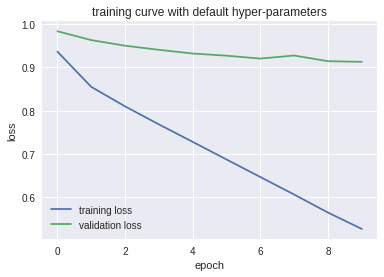

In [32]:
plt.plot(train_loss_list,label = 'training loss')
plt.plot(val_loss_list,label = 'validation loss')
plt.title("training curve with default hyper-parameters")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

No handles with labels found to put in legend.


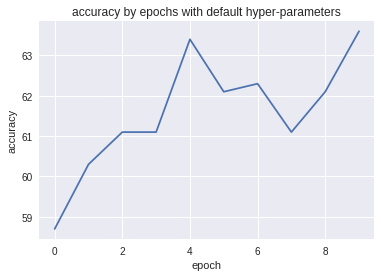

In [33]:
plt.plot(accuracy_list)
plt.title("accuracy by epochs with default hyper-parameters")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

CNN: Tune Hidden_Size

In [26]:
learning_rate = 3e-4
num_epochs = 10 # number epoch to train
num_classes = len(train_data['label_num'].unique())


train_loss_history = []
val_loss_history = []
val_acc_history = []
best_acc_history = []

for hid_size in [100,200,300,500,1000]:
  
  model = CNN(weights_matrix, hidden_size=hid_size, num_layers=2, num_classes= num_classes, kernel_size= 3)
  # Criterion and Optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


  train_loss_list = []
  val_loss_list = []
  accuracy_list = []
  best_acc = 0
  
  print("\n")
  print("Testing Parameter:Hidden_Size = {} ".format(hid_size))
  for epoch in range(num_epochs):
      running_loss = 0
      for i, (data_1, lengths_1, data_2, lengths_2, labels) in enumerate(train_loader):
          labels = labels.to(device)

          model.train()
          optimizer.zero_grad()
          # Forward pass
          outputs = model(data_1, data_2)

          loss = criterion(outputs, labels)
          # Backward and optimize
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * len(data_1) / len(train_loader.dataset)
      
      # validate
      val_acc,val_loss = test_model(val_loader, model)
      print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                 epoch+1, num_epochs, i+1, len(train_loader), val_acc))

      train_loss_list.append(running_loss)
      val_loss_list.append(val_loss)
      accuracy_list.append(val_acc)

      if val_acc >= best_acc:
        best_acc = val_acc
      else:
        best_acc = best_acc
        
  train_loss_history.append(train_loss_list)
  val_loss_history.append(val_loss_list)
  val_acc_history.append(accuracy_list)
  best_acc_history.append(best_acc)



Testing Parameter:Hidden_Size = 100 
Epoch: [1/10], Step: [3125/3125], Validation Acc: 56.5
Epoch: [2/10], Step: [3125/3125], Validation Acc: 59.1
Epoch: [3/10], Step: [3125/3125], Validation Acc: 61.2
Epoch: [4/10], Step: [3125/3125], Validation Acc: 62.3
Epoch: [5/10], Step: [3125/3125], Validation Acc: 61.7
Epoch: [6/10], Step: [3125/3125], Validation Acc: 63.0
Epoch: [7/10], Step: [3125/3125], Validation Acc: 62.2
Epoch: [8/10], Step: [3125/3125], Validation Acc: 61.6
Epoch: [9/10], Step: [3125/3125], Validation Acc: 62.4
Epoch: [10/10], Step: [3125/3125], Validation Acc: 61.8


Testing Parameter:Hidden_Size = 200 
Epoch: [1/10], Step: [3125/3125], Validation Acc: 57.8
Epoch: [2/10], Step: [3125/3125], Validation Acc: 60.2
Epoch: [3/10], Step: [3125/3125], Validation Acc: 61.7
Epoch: [4/10], Step: [3125/3125], Validation Acc: 61.8
Epoch: [5/10], Step: [3125/3125], Validation Acc: 63.5
Epoch: [6/10], Step: [3125/3125], Validation Acc: 63.2
Epoch: [7/10], Step: [3125/3125], Validat

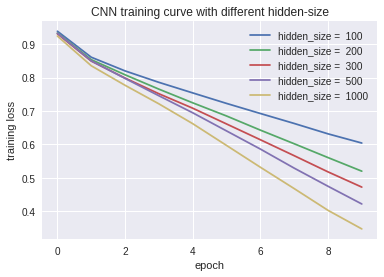

In [27]:
for (i,hid_size) in enumerate([100,200,300,500,1000]):
    plt.plot(train_loss_history[i],label = 'hidden_size =  {}'.format(hid_size))

plt.title("CNN training curve with different hidden-size")
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.legend()

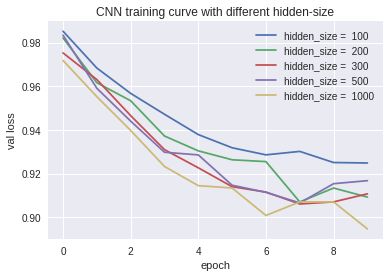

In [28]:
for (i,hid_size) in enumerate([100,200,300,500,1000]):
    plt.plot(val_loss_history[i],label = 'hidden_size =  {}'.format(hid_size))

plt.title("CNN training curve with different hidden-size")
plt.xlabel("epoch")
plt.ylabel("val loss")
plt.legend()

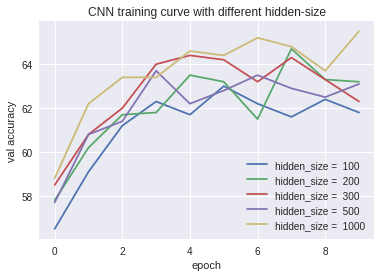

In [29]:
for (i,hid_size) in enumerate([100,200,300,500,1000]):
    plt.plot(val_acc_history[i],label = 'hidden_size =  {}'.format(hid_size))

plt.title("CNN training curve with different hidden-size")
plt.xlabel("epoch")
plt.ylabel("val accuracy")
plt.legend()

In [30]:
from collections import OrderedDict
pd.DataFrame(OrderedDict({'hidden-size':[100,200,300,500,1000],'best_val_acc':best_acc_history}))

,hidden-size,best_val_acc
0,100,63.0
1,200,64.7
2,300,64.4
3,500,63.7
4,1000,65.5


CNN: Kernel Size

In [34]:
learning_rate = 3e-4
num_epochs = 15 # number epoch to train
num_classes = len(train_data['label_num'].unique())


train_loss_history = []
val_loss_history = []
val_acc_history = []
best_acc_history = []

for kernel in [2,3,5,7,9]:
 
  model = CNN(weights_matrix, hidden_size=400, num_layers=2, num_classes= num_classes, kernel_size= kernel)
  # Criterion and Optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


  train_loss_list = []
  val_loss_list = []
  accuracy_list = []
  best_acc = 0
  
  print("\n")
  print("Testing Parameter:Kernel_Size = {} ".format(kernel))
  for epoch in range(num_epochs):
      running_loss = 0
      for i, (data_1, lengths_1, data_2, lengths_2, labels) in enumerate(train_loader):
          labels = labels.to(device)

          model.train()
          optimizer.zero_grad()
          # Forward pass
          outputs = model(data_1, data_2)

          loss = criterion(outputs, labels)
          # Backward and optimize
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * len(data_1) / len(train_loader.dataset)
          
          
      # validate
      val_acc,val_loss = test_model(val_loader, model)
      print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                 epoch+1, num_epochs, i+1, len(train_loader), val_acc))

      train_loss_list.append(running_loss)
      val_loss_list.append(val_loss)
      accuracy_list.append(val_acc)

      if val_acc >= best_acc:
        best_acc = val_acc
      else:
        best_acc = best_acc
        
  train_loss_history.append(train_loss_list)
  val_loss_history.append(val_loss_list)
  val_acc_history.append(accuracy_list)
  best_acc_history.append(best_acc)



Testing Parameter:Kernel_Size = 2 
Epoch: [1/15], Step: [3125/3125], Validation Acc: 58.9
Epoch: [2/15], Step: [3125/3125], Validation Acc: 59.8
Epoch: [3/15], Step: [3125/3125], Validation Acc: 62.6
Epoch: [4/15], Step: [3125/3125], Validation Acc: 62.9
Epoch: [5/15], Step: [3125/3125], Validation Acc: 63.2
Epoch: [6/15], Step: [3125/3125], Validation Acc: 64.1
Epoch: [7/15], Step: [3125/3125], Validation Acc: 64.5
Epoch: [8/15], Step: [3125/3125], Validation Acc: 65.1
Epoch: [9/15], Step: [3125/3125], Validation Acc: 64.9
Epoch: [10/15], Step: [3125/3125], Validation Acc: 66.2
Epoch: [11/15], Step: [3125/3125], Validation Acc: 65.8
Epoch: [12/15], Step: [3125/3125], Validation Acc: 65.0
Epoch: [13/15], Step: [3125/3125], Validation Acc: 66.3
Epoch: [14/15], Step: [3125/3125], Validation Acc: 65.0
Epoch: [15/15], Step: [3125/3125], Validation Acc: 64.3


Testing Parameter:Kernel_Size = 3 
Epoch: [1/15], Step: [3125/3125], Validation Acc: 60.0
Epoch: [2/15], Step: [3125/3125], Valida

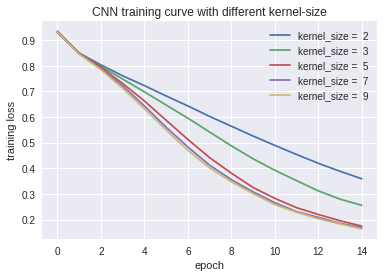

In [35]:
for (i,kernel_size) in enumerate([2,3,5,7,9]):
    plt.plot(train_loss_history[i],label = 'kernel_size =  {}'.format(kernel_size))

plt.title("CNN training curve with different kernel-size")
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.legend()




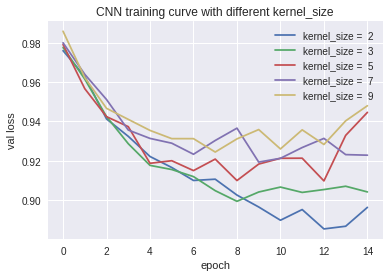

In [36]:
for (i,kernel_size) in enumerate([2,3,5,7,9]):
    plt.plot(val_loss_history[i],label = 'kernel_size =  {}'.format(kernel_size))

plt.title("CNN training curve with different kernel_size")
plt.xlabel("epoch")
plt.ylabel("val loss")
plt.legend()




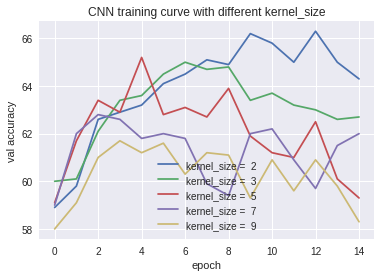

In [37]:
for (i,kernel_size) in enumerate([2,3,5,7,9]):
    plt.plot(val_acc_history[i],label = 'kernel_size =  {}'.format(kernel_size))

plt.title("CNN training curve with different kernel_size")
plt.xlabel("epoch")
plt.ylabel("val accuracy")
plt.legend()

In [38]:
pd.DataFrame(OrderedDict({'kernel-size':[2,3,5,7,9],'best_val_acc':best_acc_history}))

,hidden-size,best_val_acc
0,2,66.3
1,3,65.0
2,5,65.2
3,7,62.8
4,9,61.7


In [0]:
class RNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers, num_classes):
        # RNN Accepts the following hyperparams:
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # vocab_size: vocabulary size
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        num_embeddings, embedding_dim = weights_matrix.size()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim,padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False
        
        self.bi_gru = nn.GRU(embedding_dim, hidden_size, num_layers=1, batch_first=True, bidirectional=True)

        
        self.fc1 = nn.Linear(4 * hidden_size, 2 * hidden_size)
        self.fc2 = nn.Linear(2 * hidden_size, num_classes)
        
        self.bi_gru = self.bi_gru.to(device)
        self.fc1 = self.fc1.to(device)
        self.fc2 = self.fc2.to(device)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        
        hidden = torch.randn(self.num_layers * 2 , batch_size, self.hidden_size)

        return hidden
    
    
    def forward(self, x, y):
        batch_size_x = x.size()[0]
        
        #initiate hidden state
        #dim = [num_layers * direction,batch_size_x,hidden_size]
        hidden_x = self.init_hidden(batch_size_x).to(device)
        
        # get embedding of characters
        # in: dim = [batch_size_x,seq_lengths]; out: dim = [batch_size_x,seq_lengths,hidden_size]
        embed_x = self.embedding(x).to(device)     
        rnn_out_x, h_x  = self.bi_gru(embed_x,hidden_x)
        
        #get the last hidden state
        # dim = [batch_size_x,hidden_size * 2]
        h_x = h_x.transpose(0,1).contiguous().view(batch_size_x,-1)
        
        batch_size_y = y.size()[0]
        hidden_y = self.init_hidden(batch_size_y).to(device)
        
        embed_y = self.embedding(y).to(device) 
        rnn_out_y, h_y = self.bi_gru(embed_y, hidden_y)
        h_y = h_y.transpose(0,1).contiguous().view(batch_size_y,-1)
        
        #concatenate two sentences into one matrix
        # dim = [batch_size,2 * hidden_size * 2]
        run_out = torch.cat([h_x, h_y], 1)
        
        # in: dim[batch_size, 4 * hidden_size]; out: dim[batch_size, 2 * hidden_size]
        out = self.fc1(run_out)
        # in: dim[batch_size, 2 * hidden_size]; out: dim[batch_size, class_number]
        logits = self.fc2(out)
        
        return logits


In [41]:
model = RNN(weights_matrix, hidden_size=300, num_layers=1, num_classes = 3)
learning_rate = 3e-4
num_epochs = 15 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_loss_list = []
val_loss_list = []
accuracy_list = []
best_acc = 0


for epoch in range(num_epochs):
    running_loss = 0
    for i, (data_1, lengths_1, data_2, lengths_2, labels) in enumerate(train_loader):
        labels = labels.to(device)
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data_1,data_2)

        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()

        optimizer.step()
        running_loss += loss.item() * len(data_1) / len(train_loader.dataset)
        
    # validate
    val_acc, val_loss = test_model(val_loader, model)
    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
               epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    
    
    train_loss_list.append(running_loss)
    val_loss_list.append(val_loss)
    accuracy_list.append(val_acc)
    
    if val_acc >= best_acc:
      best_acc = val_acc
    else:
      best_acc = best_acc

Epoch: [1/15], Step: [3125/3125], Validation Acc: 55.6
Epoch: [2/15], Step: [3125/3125], Validation Acc: 55.8
Epoch: [3/15], Step: [3125/3125], Validation Acc: 58.2
Epoch: [4/15], Step: [3125/3125], Validation Acc: 58.5
Epoch: [5/15], Step: [3125/3125], Validation Acc: 58.9
Epoch: [6/15], Step: [3125/3125], Validation Acc: 60.4
Epoch: [7/15], Step: [3125/3125], Validation Acc: 59.1
Epoch: [8/15], Step: [3125/3125], Validation Acc: 60.5
Epoch: [9/15], Step: [3125/3125], Validation Acc: 61.9
Epoch: [10/15], Step: [3125/3125], Validation Acc: 62.3
Epoch: [11/15], Step: [3125/3125], Validation Acc: 62.0
Epoch: [12/15], Step: [3125/3125], Validation Acc: 62.3
Epoch: [13/15], Step: [3125/3125], Validation Acc: 62.6
Epoch: [14/15], Step: [3125/3125], Validation Acc: 61.4
Epoch: [15/15], Step: [3125/3125], Validation Acc: 63.5


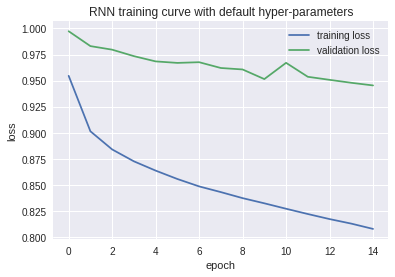

In [43]:
plt.plot(train_loss_list,label = 'training loss')
plt.plot(val_loss_list,label = 'validation loss')
plt.title("RNN training curve with default hyper-parameters")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

No handles with labels found to put in legend.


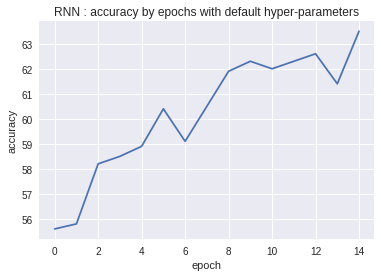

In [44]:
plt.plot(accuracy_list)
plt.title("RNN : accuracy by epochs with default hyper-parameters")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

RNN: Hidden_Size

In [0]:
learning_rate = 3e-4
num_epochs = 15 # number epoch to train
num_label = len(train_data['label_num'].unique())


train_loss_history = []
val_loss_history = []
val_acc_history = []
best_acc_history = []

for hid_size in [100,200,300,500,700]:
  
  model = RNN(weights_matrix, hidden_size = hid_size, num_layers=1, num_classes = num_label)
  # Criterion and Optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


  train_loss_list = []
  val_loss_list = []
  accuracy_list = []
  best_acc = 0
  
  print("\n")
  print("Testing Parameter:Hidden_Size = {} ".format(hid_size))
  for epoch in range(num_epochs):
      running_loss = 0
      for i, (data_1, lengths_1, data_2, lengths_2, labels) in enumerate(train_loader):
          labels = labels.to(device)

          model.train()
          optimizer.zero_grad()
          # Forward pass
          outputs = model(data_1, data_2)

          loss = criterion(outputs, labels)
          # Backward and optimize
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * len(data_1) / len(train_loader.dataset)
      
      # validate
      val_acc,val_loss = test_model(val_loader, model)
      print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                 epoch+1, num_epochs, i+1, len(train_loader), val_acc))

      train_loss_list.append(running_loss)
      val_loss_list.append(val_loss)
      accuracy_list.append(val_acc)

      if val_acc >= best_acc:
        best_acc = val_acc
      else:
        best_acc = best_acc
        
  train_loss_history.append(train_loss_list)
  val_loss_history.append(val_loss_list)
  val_acc_history.append(accuracy_list)
  best_acc_history.append(best_acc)



Testing Parameter:Hidden_Size = 100 
Epoch: [1/15], Step: [3125/3125], Validation Acc: 55.7
Epoch: [2/15], Step: [3125/3125], Validation Acc: 56.9
Epoch: [3/15], Step: [3125/3125], Validation Acc: 57.2
Epoch: [4/15], Step: [3125/3125], Validation Acc: 56.8
Epoch: [5/15], Step: [3125/3125], Validation Acc: 58.1
Epoch: [6/15], Step: [3125/3125], Validation Acc: 59.8
Epoch: [7/15], Step: [3125/3125], Validation Acc: 58.9
Epoch: [8/15], Step: [3125/3125], Validation Acc: 59.8
Epoch: [9/15], Step: [3125/3125], Validation Acc: 60.0
Epoch: [10/15], Step: [3125/3125], Validation Acc: 59.2
Epoch: [11/15], Step: [3125/3125], Validation Acc: 60.0
Epoch: [12/15], Step: [3125/3125], Validation Acc: 61.5
Epoch: [13/15], Step: [3125/3125], Validation Acc: 60.7
Epoch: [14/15], Step: [3125/3125], Validation Acc: 59.3
Epoch: [15/15], Step: [3125/3125], Validation Acc: 61.5


Testing Parameter:Hidden_Size = 200 
Epoch: [1/15], Step: [3125/3125], Validation Acc: 56.6
Epoch: [2/15], Step: [3125/3125], Va

In [1]:
for (i,hid_size) in enumerate([100,200,300,500,700]):
    plt.plot(train_loss_history[i],label = 'hidden_size =  {}'.format(hid_size))

plt.title("RNN training curve with different hidden-size")
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.legend()

NameError: ignored

In [0]:
for (i,hid_size) in enumerate([100,200,300,500,700]):
    plt.plot(val_loss_history[i],label = 'hidden_size =  {}'.format(hid_size))

plt.title("RNN training curve with different hidden-size")
plt.xlabel("epoch")
plt.ylabel("val loss")
plt.legend()

In [0]:
for (i,hid_size) in enumerate([100,200,300,500,700]):
    plt.plot(val_acc_history[i],label = 'hidden_size =  {}'.format(hid_size))

plt.title("RNN training curve with different hidden_size")
plt.xlabel("epoch")
plt.ylabel("val accuracy")
plt.legend()

In [0]:
pd.DataFrame(OrderedDict({'hidden-size':[100,200,300,500,700],'best_val_acc':best_acc_history}))

CNN: Tune Regularization(weights_decay (l2 regularization))

In [0]:
learning_rate = 3e-4
num_epochs = 15 # number epoch to train
num_classes = len(train_data['label_num'].unique())
decay_rate = [1e-5,2e-5,3e-5]


train_loss_history = []
val_loss_history = []
val_acc_history = []
best_acc_history = []

for decay in decay_rate:
 
  model = CNN(weights_matrix, hidden_size = 400, num_layers=2, num_classes= num_classes, kernel_size= 2)
  # Criterion and Optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = decay)


  train_loss_list = []
  val_loss_list = []
  accuracy_list = []
  best_acc = 0
  
  print("\n")
  print("Testing Parameter:Kernel_Size = {} ".format(kernel))
  for epoch in range(num_epochs):
      running_loss = 0
      for i, (data_1, lengths_1, data_2, lengths_2, labels) in enumerate(train_loader):
          labels = labels.to(device)

          model.train()
          optimizer.zero_grad()
          # Forward pass
          outputs = model(data_1, data_2)

          loss = criterion(outputs, labels)
          # Backward and optimize
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * len(data_1) / len(train_loader.dataset)
          
          
      # validate
      val_acc,val_loss = test_model(val_loader, model)
      print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                 epoch+1, num_epochs, i+1, len(train_loader), val_acc))

      train_loss_list.append(running_loss)
      val_loss_list.append(val_loss)
      accuracy_list.append(val_acc)

      if val_acc >= best_acc:
        best_acc = val_acc
      else:
        best_acc = best_acc
        
  train_loss_history.append(train_loss_list)
  val_loss_history.append(val_loss_list)
  val_acc_history.append(accuracy_list)
  best_acc_history.append(best_acc)